In [1]:
import numpy as np
from pathlib import Path
import torch
import torch.nn as nn
import torchvision.models as models
import torch.utils.data as data
import os
import glob
import PIL
import matplotlib.pyplot as plt

In [2]:
model = models.vision_transformer.vit_b_16()

In [3]:
images_dir = ('../data/images/')
images_names = sorted(filter(os.path.isfile, glob.glob(images_dir + '*')))
images_ids = [(os.path.basename(name)).split('.')[0] for name in images_names]
images_ids[:5]

['0000000000000_1',
 '0000000000000_2',
 '0000000000000_3',
 '0000000000000_4',
 '0000000000000_5']

In [4]:
BATCH_SIZE = 16
data_loader = torch.utils.data.DataLoader(dataset=images_dir,
                                          batch_size=BATCH_SIZE,
                                          shuffle=False)

In [5]:
preprocessing = models.ViT_B_16_Weights.DEFAULT.transforms()

In [6]:
img = PIL.Image.open(images_names[0])
img = preprocessing(img)

# Add batch dimension
img = img.unsqueeze(0)

feats = model._process_input(img)

# Expand the class token to the full batch
batch_class_token = model.class_token.expand(img.shape[0], -1, -1)
feats = torch.cat([batch_class_token, feats], dim=1)

feats = model.encoder(feats)

# We're only interested in the representation of the classifier token that we appended at position 0
feats = feats[:, 0]

print(feats.shape)

torch.Size([1, 768])


In [8]:
embeddings = []
for i, name in enumerate(images_names):
    
    img = PIL.Image.open(name)
    if img.mode == 'L':
        img = img.convert('RGB')
    img = preprocessing(img)

    # Add batch dimension
    img = img.unsqueeze(0)

    feats = model._process_input(img).cpu()

    # Expand the class token to the full batch
    batch_class_token = model.class_token.expand(img.shape[0], -1, -1)
    feats = torch.cat([batch_class_token, feats], dim=1)

    feats = model.encoder(feats).cpu()

    # We're only interested in the representation of the classifier token that we appended at position 0
    feats = feats[:, 0].detach().numpy()
    print(f"Image {i}/{len(images_names)}")
    embeddings.append(feats)

Image 0/32960
Image 1/32960
Image 2/32960
Image 3/32960
Image 4/32960
Image 5/32960
Image 6/32960
Image 7/32960
Image 8/32960
Image 9/32960
Image 10/32960
Image 11/32960
Image 12/32960
Image 13/32960
Image 14/32960
Image 15/32960
Image 16/32960
Image 17/32960
Image 18/32960
Image 19/32960
Image 20/32960
Image 21/32960
Image 22/32960
Image 23/32960
Image 24/32960
Image 25/32960
Image 26/32960
Image 27/32960
Image 28/32960
Image 29/32960
Image 30/32960
Image 31/32960
Image 32/32960
Image 33/32960
Image 34/32960
Image 35/32960
Image 36/32960
Image 37/32960
Image 38/32960
Image 39/32960
Image 40/32960
Image 41/32960
Image 42/32960
Image 43/32960
Image 44/32960
Image 45/32960
Image 46/32960
Image 47/32960
Image 48/32960
Image 49/32960
Image 50/32960
Image 51/32960
Image 52/32960
Image 53/32960
Image 54/32960
Image 55/32960
Image 56/32960
Image 57/32960
Image 58/32960
Image 59/32960
Image 60/32960
Image 61/32960
Image 62/32960
Image 63/32960
Image 64/32960
Image 65/32960
Image 66/32960
Image

RuntimeError: The size of tensor a (4) must match the size of tensor b (3) at non-singleton dimension 0

In [9]:
import pickle 
with open('embeddings_transformer.pckl', 'wb') as f:
     pickle.dump(embeddings, f)

In [10]:
len(embeddings)

17342

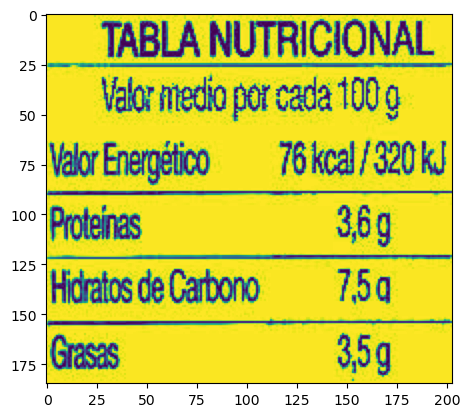

In [7]:
img = np.array(PIL.Image.open(images_names[105]))
plt.imshow(img)

In [8]:
np.dstack((img, img, img)).shape

(185, 203, 3)

In [13]:
img = PIL.Image.open(images_names[105])
print(img.mode)
img = img.convert('RGB')
print(img.mode)

L
RGB


In [19]:

def extract_embeddings(model: torch.nn.Module):
    """Utility to compute embeddings."""

    def pp(batch):
        images = batch["image"]
        # `transformation_chain` is a compostion of preprocessing
        # transformations we apply to the input images to prepare them
        # for the model. For more details, check out the accompanying Colab Notebook.
        image_batch_transformed = torch.stack(
            [transformation_chain(image) for image in images]
        )
        new_batch = {"pixel_values": image_batch_transformed.to(device)}
        with torch.no_grad():
            embeddings = model(**new_batch).last_hidden_state[:, 0].cpu()
        return {"embeddings": embeddings}

    return pp


In [20]:
torch.cuda.is_available()

True

In [21]:
extract_fn = extract_embeddings(model)
candidate_subset_emb = data_loader.map(extract_fn, batched=True, batch_size=batch_size)

AttributeError: 'DataLoader' object has no attribute 'map'

2023-04-24 16:19:52.083685: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-04-24 16:19:52.086866: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2023-04-24 16:19:52.184010: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:61:00.0 name: NVIDIA GeForce GTX 1660 computeCapability: 7.5
coreClock: 1.785GHz coreCount: 22 deviceMemorySize: 5.80GiB deviceMemoryBandwidth: 178.86GiB/s
2023-04-24 16:19:52.184081: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2023-04-24 16:19:52.446923: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2023-04-24 16:19:52.447091: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.1

ValueError: Unknown SavedObject type: None